In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import binance as bnb
from dotenv import load_dotenv
import requests
import json
import os

load_dotenv()

True

In [18]:
get_coins_data()

,Coin,Symbol,Circulating Supply,Max Supply,Total Supply,Price,Market Cap,Tag_Meme,Tag_Seed,Tag_bnbchain,...,Tag_Infrastructure,Tag_Monitoring,Tag_NFT,Tag_Metaverse,Tag_Launchpad,Tag_liquid_staking,Tag_pow,Tag_storage-zone,Tag_RWA,Tag_Megadrop
0,1000CAT,1000CAT,8150000000,9.000000e+09,8099953034,7.993954e-06,6.515073e+07,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,1000CHEEMS,1000CHEEMS,187495034775,2.036730e+11,203672952645,1.815764e-06,3.404468e+08,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2,1000SATS,1000SATS,2100000000000,2.100000e+12,2100000000000,1.443596e-07,3.031551e+08,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,1INCH,1INCH,1397500000,NaN,1500000000,2.161008e-01,3.020008e+08,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1MBABYDOGE,1MBABYDOGE,175284980046,NaN,202637675722,1.390182e-09,2.436781e+08,True,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,ZEN,ZEN,16000000,2.100000e+07,15932387,9.730000e+00,1.556492e+08,False,False,False,...,False,False,False,False,False,False,True,False,False,False
398,ZIL,ZIL,20340189067,2.100000e+10,20372686491,1.293493e-02,2.630988e+08,False,False,False,...,False,False,False,False,False,False,True,False,False,False
399,ZK,ZK,3675000000,2.100000e+10,21000000000,8.184943e-02,3.007966e+08,False,True,False,...,True,False,False,False,False,False,False,False,False,False
400,ZRO,ZRO,250000000,1.000000e+09,1000000000,2.880000e+00,7.191771e+08,False,True,False,...,True,False,False,False,False,False,False,False,False,False


In [2]:
def get_coins_data():
    url = "https://www.binance.com/bapi/apex/v1/friendly/apex/marketing/complianceSymbolList"
    response = requests.get(url)
    json_data = json.loads(response.text)

    coin_data = []
    for i in range(len(json_data['data'])):
        try:
            coin_info = {
                'Coin': json_data['data'][i].get('name', 'N/A'),
                'Symbol': json_data['data'][i].get('baseAsset', 'N/A'),
                'Circulating Supply': json_data['data'][i].get('circulatingSupply', 0),
                'Max Supply': json_data['data'][i].get('maxSupply', 0),
                'Total Supply': json_data['data'][i].get('totalSupply', 0),
                'Price': json_data['data'][i].get('price', 0),
                'Market Cap': json_data['data'][i].get('marketCap', 0)
            }
            
            # Add tags as separate columns
            tags = json_data['data'][i].get('tags', [])
            for tag in tags:
                coin_info[f'Tag_{tag}'] = True
                
            coin_data.append(coin_info)
        except Exception as e:
            print(f"Error processing coin at index {i}: {e}")

    # Create DataFrame
    coins_df = pd.DataFrame(coin_data)

    # Fill NaN values in tag columns with False
    tag_columns = [col for col in coins_df.columns if col.startswith('Tag_')]
    coins_df[tag_columns] = coins_df[tag_columns].fillna(False)
    return coins_df

def get_history():
    history = pd.read_csv('history.csv')
    return history

In [5]:
# Get tag columns once to avoid repeated filtering
history = get_history()
coins_df = get_coins_data()
history['Coin']= history.Coin.apply(lambda x: x.replace('USDT',''))
final_df = history.merge(coins_df, on = 'Coin', how = 'left')
final_df[final_df['Tag_defi'] == True]

tag_columns = [col for col in final_df.columns if 'Tag' in col]

# Use inplace operations where possible to avoid copies
temp_df = final_df.copy()
temp_df = temp_df[['dateTime']+tag_columns]
temp_df.fillna(0, inplace=True)
temp_df[tag_columns] = temp_df[tag_columns].astype(int)
temp_df['rowsum'] = temp_df[tag_columns].sum(axis=1)
# Normalize the tag columns by dividing each value by the row sum
# This is a fast vectorized operation that works well for large dataframes
temp_df[tag_columns] = temp_df[tag_columns].div(temp_df['rowsum'], axis=0)
temp_df = temp_df[['dateTime']+tag_columns].groupby('dateTime').sum()
temp_df['rowsum'] = temp_df[tag_columns].sum(axis=1)
temp_df[tag_columns] = temp_df[tag_columns].div(temp_df['rowsum'], axis=0)

history['Coin']= history.Coin.apply(lambda x: x.replace('USDT',''))
final_df = history.merge(coins_df, on = 'Coin', how = 'left')
final_df['Market Cap'] = final_df['close'] * final_df['Circulating Supply']
market_cap_by_day = final_df.groupby(['dateTime']).agg({'Market Cap': 'sum'}).reset_index().rename(columns = {'Market Cap': 'Market Cap Total'})

temp_df = temp_df.merge(market_cap_by_day, on = 'dateTime', how = 'left').drop(columns = ['rowsum'])
temp_df[tag_columns] = temp_df[tag_columns].multiply(temp_df['Market Cap Total'], axis=0)
temp_df


,dateTime,Tag_Meme,Tag_Seed,Tag_bnbchain,Tag_Launchpool,Tag_newListing,Tag_defi,Tag_Polkadot,Tag_Layer1_Layer2,Tag_Gaming,...,Tag_Monitoring,Tag_NFT,Tag_Metaverse,Tag_Launchpad,Tag_liquid_staking,Tag_pow,Tag_storage-zone,Tag_RWA,Tag_Megadrop,Market Cap Total
0,2024-03-17 00:00:00,4.181535e+10,2.208460e+11,7.213840e+10,1.034307e+11,0.000000e+00,4.512458e+11,2.215383e+10,4.991534e+11,8.764608e+10,...,1.151999e+11,9.636915e+10,3.433843e+10,9.927684e+10,3.461536e+10,1.343076e+11,4.223073e+10,5.123073e+10,0.000000e+00,2.575382e+12
1,2024-03-18 00:00:00,4.071264e+10,2.177183e+11,7.023605e+10,1.033993e+11,0.000000e+00,4.420422e+11,2.156961e+10,4.859903e+11,8.533478e+10,...,1.121620e+11,9.382781e+10,3.343290e+10,9.665883e+10,3.370252e+10,1.307658e+11,4.111707e+10,4.987973e+10,0.000000e+00,2.515556e+12
2,2024-03-19 00:00:00,3.717672e+10,1.988093e+11,6.413599e+10,9.441901e+10,0.000000e+00,4.036505e+11,1.969627e+10,4.437817e+11,7.792339e+10,...,1.024206e+11,8.567879e+10,3.052923e+10,8.826393e+10,3.077543e+10,1.194087e+11,3.754602e+10,4.554763e+10,0.000000e+00,2.297078e+12
3,2024-03-20 00:00:00,4.082960e+10,2.183437e+11,7.043781e+10,1.036964e+11,0.000000e+00,4.433121e+11,2.163157e+10,4.873864e+11,8.557992e+10,...,1.124842e+11,9.409735e+10,3.352894e+10,9.693649e+10,3.379934e+10,1.311414e+11,4.123519e+10,5.002302e+10,0.000000e+00,2.522782e+12
4,2024-03-21 00:00:00,3.993108e+10,2.135387e+11,6.888772e+10,1.014144e+11,0.000000e+00,4.335563e+11,2.115554e+10,4.687274e+11,8.369660e+10,...,1.100088e+11,9.202659e+10,3.279109e+10,9.480326e+10,3.305553e+10,1.282555e+11,4.032775e+10,4.892218e+10,0.000000e+00,2.459331e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2025-03-12 00:00:00,6.138927e+10,3.060436e+11,7.526956e+10,1.432040e+11,1.060770e+10,4.105407e+11,1.940984e+10,4.457493e+11,7.955778e+10,...,9.524364e+10,8.914986e+10,2.934046e+10,8.429740e+10,2.956615e+10,1.094625e+11,3.441862e+10,4.570341e+10,5.303852e+09,2.518766e+12
361,2025-03-13 00:00:00,5.971903e+10,2.999125e+11,7.322168e+10,1.393078e+11,1.031910e+10,3.993710e+11,1.888175e+10,4.358172e+11,7.739323e+10,...,9.265232e+10,8.891988e+10,2.854218e+10,8.200389e+10,2.876174e+10,1.064843e+11,3.348218e+10,4.445994e+10,5.159548e+09,2.456823e+12
362,2025-03-14 00:00:00,6.176234e+10,3.101741e+11,7.572698e+10,1.440743e+11,1.067217e+10,4.130356e+11,1.952780e+10,4.507288e+11,8.004126e+10,...,9.582245e+10,9.196230e+10,2.951876e+10,8.480968e+10,2.974583e+10,1.101277e+11,3.462778e+10,4.598115e+10,5.336084e+09,2.540884e+12
363,2025-03-15 00:00:00,6.237045e+10,3.132281e+11,7.647259e+10,1.454928e+11,1.077725e+10,4.171024e+11,1.972007e+10,4.551667e+11,8.082935e+10,...,9.676592e+10,9.286776e+10,2.980941e+10,8.564471e+10,3.003871e+10,1.112120e+11,3.496873e+10,4.643388e+10,5.388623e+09,2.565902e+12


In [6]:
timeseries_df = temp_df.melt(id_vars = ['dateTime','Market Cap Total'], value_vars = tag_columns, var_name = 'Tag', value_name = 'Market Cap by Tag')
timeseries_df['Percentage'] = timeseries_df['Market Cap by Tag'] / timeseries_df['Market Cap Total']
timeseries_df.drop(columns = ['Market Cap by Tag','Market Cap Total'], inplace = True)


timeseries_df = timeseries_df[timeseries_df['Percentage']>0.00]
pivot_df = timeseries_df[['dateTime','Tag','Percentage']].pivot(index='dateTime', columns='Tag', values='Percentage')

# Create the interactive plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a Plotly figure
fig = px.line(pivot_df.reset_index(), x='dateTime', y=pivot_df.columns,
              title='Tag Percentage Over Time',
              labels={'value': 'Percentage', 'variable': 'Tag'},
              markers=True)  # Add markers to the lines

# Customize the layout
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Percentage',
    legend_title='Tags',
    hovermode='x unified',
    template='plotly_white',
    height=600,
    width=1500
)

# Add hover information
fig.update_traces(
    hovertemplate='<b>%{y:.2%}</b><extra></extra>'
)

# Format y-axis as percentage
fig.update_layout(yaxis_tickformat='.1%')

# Show the plot
fig.show()


In [7]:
# Filter coins with Tag_Seed
coins_df
seed_coins = coins_df[coins_df['Tag_Seed'] == True]

# # Calculate market cap for each coin (using close price)


# # Sort by market cap and get top 10 for better visualization
top_seed_coins = seed_coins.sort_values('Market Cap', ascending=False).head(10)
other_market_cap = seed_coins.iloc[20:]['Market Cap'].sum() if len(seed_coins) > 10 else 0

# # Create data for pie chart
labels = list(top_seed_coins['Coin'])
if other_market_cap > 0:
    labels.append('Others')
    
values = list(top_seed_coins['Market Cap'])
if other_market_cap > 0:
    values.append(other_market_cap)

# Create pie chart
fig = px.pie(
    names=labels,
    values=values,
    title='Market Cap Distribution of Seed Coins',
    hole=0.4,
)

# Customize layout
fig.update_layout(
    legend_title="Coins",
    width=900,
    height=700
)

# Format hover text to show values in billions/millions
fig.update_traces(
    textinfo='percent+label',
    hovertemplate='<b>%{label}</b><br>Market Cap: $%{value:,.0f}<br>Percentage: %{percent}<extra></extra>'
)

# Show the chart
fig.show()

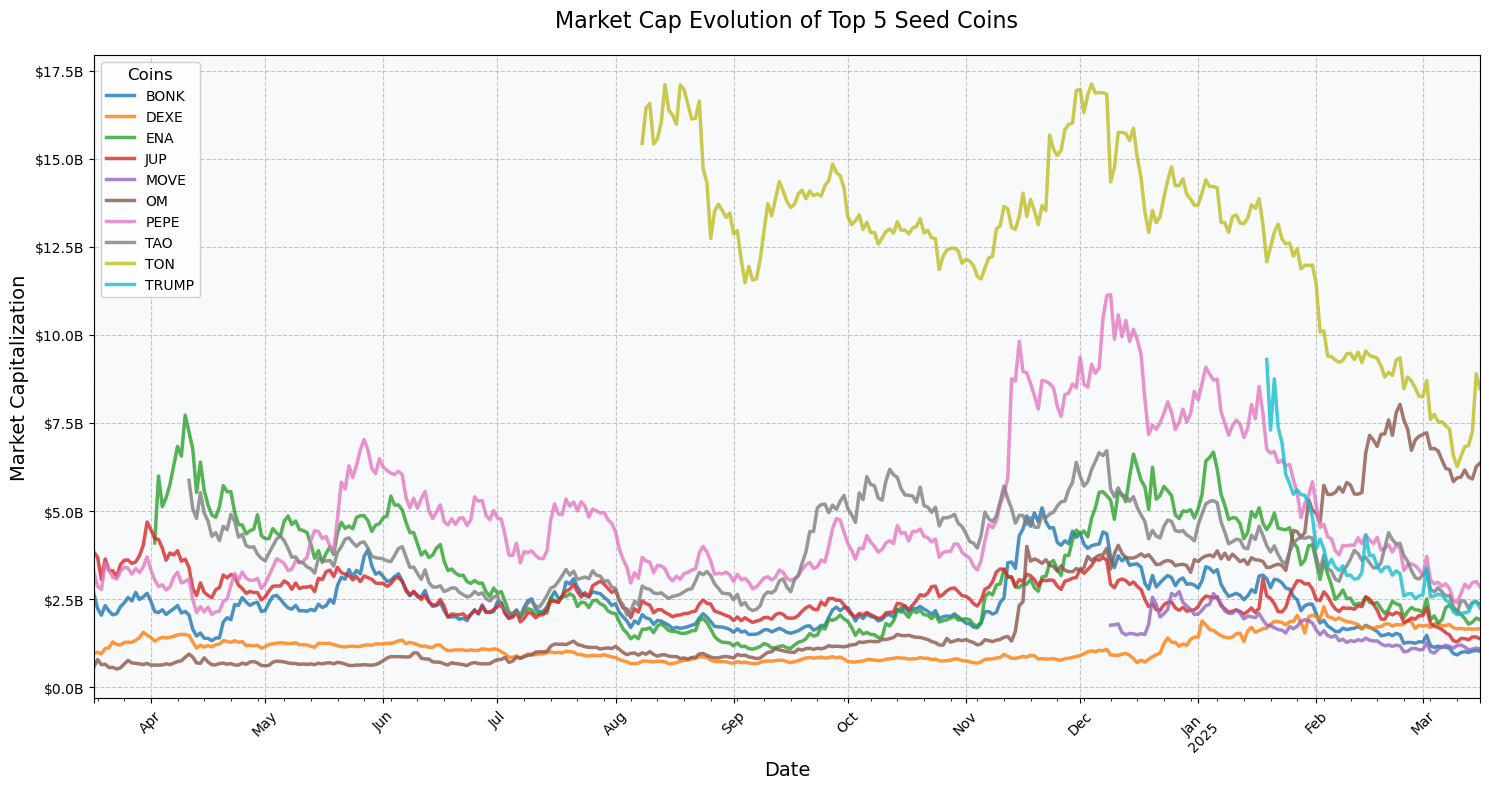

In [10]:
def get_top_coins(category, top_n = 10, coins_df = get_coins_data()):
    coins_df = coins_df[coins_df[category] == True]
    top_10_coins = coins_df.sort_values('Market Cap', ascending=False).head(top_n)
    return top_10_coins

# Get top 5 DeFi coins
top = get_top_coins('Tag_Seed', top_n = 10)[['Coin','Circulating Supply']]
top = history[history['Coin'].isin(top['Coin'])].merge(top, on = 'Coin', how = 'left')
top['Market Cap'] = top['Circulating Supply'] * top['close']
top = top[['dateTime','Coin','Market Cap']]
top['dateTime'] = pd.to_datetime(top['dateTime'], format='%Y-%m-%d %H:%M:%S')

# Create a better looking plot
plt.figure(figsize=(15, 8))
ax = plt.gca()

# Plot the data with improved styling
pivot_data = top.pivot(index='dateTime', columns='Coin', values='Market Cap')
pivot_data.plot(ax=ax, linewidth=2.5, alpha=0.8)

# Format y-axis to show billions
def billions_formatter(x, pos):
    return f'${x/1e9:.1f}B'
ax.yaxis.set_major_formatter(plt.FuncFormatter(billions_formatter))

# Improve the styling
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Market Cap Evolution of Top 5 Seed Coins', fontsize=16, pad=20)
plt.ylabel('Market Capitalization', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Coins', title_fontsize=12, fontsize=10, loc='upper left', frameon=True, facecolor='white', framealpha=0.9)

# Add some padding
plt.tight_layout()

# Add a subtle background color
ax.set_facecolor('#f8f9fa')



In [15]:
temp = coins_df[coins_df['Tag_Seed'] == True]
thresholds = [
    (0, 1_000_000, '<$1M'),
    (1_000_000, 10_000_000, '$1M-$10M'),
    (10_000_000, 50_000_000, '$10M-$50M'),
    (50_000_000, 100_000_000, '$50M-$100M'),
    (100_000_000, 500_000_000, '$100M-$500M'),
    (500_000_000, 1_000_000_000, '$500M-$1B'),
    (1_000_000_000, 5_000_000_000, '$1B-$5B'),
    (5_000_000_000, 10_000_000_000, '$5B-$10B'),
    (10_000_000_000, 50_000_000_000, '$10B-$50B'),
    (50_000_000_000, float('inf'), '>$50B')
]
def categorize_market_cap(cap):
    for low, high, label in thresholds:
        if low <= cap < high:
            return label
    return '>$10B'  # Default for very large caps

temp['Market Cap'].apply(categorize_market_cap)

0       $50M-$100M
1      $100M-$500M
2      $100M-$500M
4      $100M-$500M
7        $10M-$50M
          ...     
380      $500M-$1B
382      $10M-$50M
385     $50M-$100M
399    $100M-$500M
400      $500M-$1B
Name: Market Cap, Length: 137, dtype: object

In [17]:
# Create a function to analyze market cap distribution for any tag
def analyze_market_cap_distribution(tag=None, coins_df=get_coins_data()):
    """
    Analyze the market cap distribution of coins in a specific tag category.
    
    Parameters:
    - tag: The tag category to analyze (e.g., 'Tag_Seed', 'Tag_Meme')
    - coins_df: DataFrame containing coin data
    
    Returns:
    - DataFrame with market cap distribution analysis
    """
    # Filter by tag if specified
    if tag:
        filtered_df = coins_df[coins_df[tag] == True].copy()
    else:
        filtered_df = coins_df.copy()
    
    # Define market cap thresholds
    thresholds = [
        (0, 1_000_000, '<$1M'),
        (1_000_000, 10_000_000, '$1M-$10M'),
        (10_000_000, 50_000_000, '$10M-$50M'),
        (50_000_000, 100_000_000, '$50M-$100M'),
        (100_000_000, 500_000_000, '$100M-$500M'),
        (500_000_000, 1_000_000_000, '$500M-$1B'),
        (1_000_000_000, 5_000_000_000, '$1B-$5B'),
        (5_000_000_000, 10_000_000_000, '$5B-$10B'),
        (10_000_000_000, 50_000_000_000, '$10B-$50B'),
        (50_000_000_000, float('inf'), '>$50B')
    ]
    
    # Categorize coins by market cap
    def categorize_market_cap(cap):
        for low, high, label in thresholds:
            if low <= cap < high:
                return label
        return '>$10B'  # Default for very large caps
    
    filtered_df['Market Cap Category'] = filtered_df['Market Cap'].apply(categorize_market_cap)
    
    # Count coins in each category
    distribution = filtered_df.groupby('Market Cap Category').size().reset_index(name='Count')
    
    # Calculate percentages
    total_coins = distribution['Count'].sum()
    distribution['Percentage'] = (distribution['Count'] / total_coins * 100).round(2)
    
    # Ensure the categories are in the right order
    category_order = ['<$1M', '$1M-$10M', '$10M-$50M', '$50M-$100M', '$100M-$500M', '$500M-$1B', '$1B-$5B', '$5B-$10B', '$10B-$50B', '>$50B']
    distribution['Market Cap Category'] = pd.Categorical(
        distribution['Market Cap Category'], 
        categories=category_order, 
        ordered=True
    )
    distribution = distribution.sort_values('Market Cap Category')
    
    return distribution, filtered_df

# Create interactive widgets for tag selection
import ipywidgets as widgets
from IPython.display import display

# Get all tag columns
tag_columns = [col for col in get_coins_data().columns if col.startswith('Tag_')]
tag_options = [None] + tag_columns  # Add None option for all coins

# Create dropdown for tag selection
tag_dropdown = widgets.Dropdown(
    options=tag_options,
    description='Category:',
    value=tag_options[1]  # Default to first tag
)

# Function to update visualizations based on selected tag
def update_visualizations(tag):
    distribution, filtered_df = analyze_market_cap_distribution(tag)
    
    # Create a figure with subplots
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "pie"}, {"type": "bar"}]],
        subplot_titles=("Market Cap Distribution (%)", "Number of Coins by Market Cap")
    )
    
    # Add pie chart
    fig.add_trace(
        go.Pie(
            labels=distribution['Market Cap Category'],
            values=distribution['Percentage'],
            textinfo='label+percent',
            hoverinfo='label+percent+value',
            marker=dict(line=dict(color='#000000', width=1)),
            hole=0.4
        ),
        row=1, col=1
    )
    
    # Add bar chart
    fig.add_trace(
        go.Bar(
            x=distribution['Market Cap Category'],
            y=distribution['Count'],
            text=distribution['Percentage'],
            textposition='auto',
            hovertemplate='%{x}<br>Count: %{y}<br>Percentage: %{text:.2f}%',
            marker_color='royalblue'
        ),
        row=1, col=2
    )
    
    # Update layout
    title_text = f"Market Cap Distribution for {tag.replace('Tag_', '')} Coins" if tag else "Market Cap Distribution for All Coins"
    fig.update_layout(
        title_text=title_text,
        height=600,
        width=1200,
        showlegend=True,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    
    # Display the figure
    fig.show();
    
    # Display the distribution table
    display(distribution)

# Create interactive widget
interactive_plot = widgets.interactive(update_visualizations, tag=tag_dropdown)
display(interactive_plot);

# Initialize with default tag
update_visualizations(tag_options[1]);

interactive(children=(Dropdown(description='Category:', index=1, options=(None, 'Tag_Meme', 'Tag_Seed', 'Tag_b…

,Market Cap Category,Count,Percentage
4,$50M-$100M,4,17.39
0,$100M-$500M,12,52.17
3,$500M-$1B,2,8.70
2,$1B-$5B,3,13.04
5,$5B-$10B,1,4.35
1,$10B-$50B,1,4.35


In [59]:
analysis_df = final_df[[
    'dateTime',
    'Coin',
    'Market Cap'
]+tag_columns]
seed_df = analysis_df[analysis_df['Tag_Seed'] == True]
coin = seed_df[seed_df['Coin'] == 'OM']
# Use .loc to avoid SettingWithCopyWarning
# Create a copy of the dataframe to avoid SettingWithCopyWarning
coin = coin.copy()
coin.loc[:, 'Next Market Cap'] = coin.loc[:, 'Market Cap'].shift(-1)
coin = coin[['dateTime','Market Cap','Next Market Cap']]
coin['is_Billion'] = coin['Market Cap'] > 1_000_000_000
coin.loc[:,'next_is_Billion'] = coin['Next Market Cap'] > 1_000_000_000
# Concatenate is_Billion and next_is_Billion columns
coin.dropna(inplace=True)
coin['is_Billion'] = coin['is_Billion'].astype(str) + '->' + coin['next_is_Billion'].astype(str)
coin[coin.is_Billion.isin(['True->False','False->True'])]

,dateTime,Market Cap,Next Market Cap,is_Billion,next_is_Billion
58908,2024-07-10 00:00:00,9.188870e+08,1.002139e+09,False->True,True
58931,2024-08-02 00:00:00,1.079248e+09,9.879642e+08,True->False,False
58938,2024-08-09 00:00:00,9.389203e+08,1.015368e+09,False->True,True
58939,2024-08-10 00:00:00,1.015368e+09,9.350459e+08,True->False,False
58970,2024-09-10 00:00:00,9.946734e+08,1.010265e+09,False->True,True
58976,2024-09-16 00:00:00,1.000249e+09,9.924055e+08,True->False,False
58977,2024-09-17 00:00:00,9.924055e+08,1.085579e+09,False->True,True


In [42]:
coin[coin['is_Billion'].isin([i for i in range(110,120)])]

,dateTime,Market Cap,Next Market Cap,is_Billion
58902,2024-07-04 00:00:00,7.064582e+08,7.457688e+08,110
58903,2024-07-05 00:00:00,7.457688e+08,8.581255e+08,111
58904,2024-07-06 00:00:00,8.581255e+08,8.211773e+08,112
58905,2024-07-07 00:00:00,8.211773e+08,8.659688e+08,113
58906,2024-07-08 00:00:00,8.659688e+08,9.069804e+08,114
58907,2024-07-09 00:00:00,9.069804e+08,9.188870e+08,115
58908,2024-07-10 00:00:00,9.188870e+08,1.002139e+09,115
58909,2024-07-11 00:00:00,1.002139e+09,1.009226e+09,115
58910,2024-07-12 00:00:00,1.009226e+09,1.009415e+09,115
58911,2024-07-13 00:00:00,1.009415e+09,1.018676e+09,115
